In [1]:
import numpy as np 
import pandas as pd
import os
import glob
import itertools
import time

import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt

from tensorflow.keras import backend as K

from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LayerNormalization, Input, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, Dense, Softmax, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

from pandas import DataFrame
from typing import List
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Read the dataframe
df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')

# Rename the columns
df = df.rename(columns={
    "OriginalImagePixelSpacing[x": "OriginalImagePixelSpacingX",
    "y]": "OriginalImagePixelSpacingY",
    "OriginalImage[Width": "OriginalImageWidth",
    "Height]": "OriginalImageHeight"
})

### Format the label by a one-hot encoding

# Get all the label
unique_labels = set(itertools.chain.from_iterable(df["Finding Labels"].apply(lambda x: x.split('|')).values))

# Convert unique_labels set to a list
unique_labels_list = list(unique_labels)

# Initialize an empty matrix
one_hot_labels = pd.DataFrame(0.0, index=np.arange(len(df)), columns=unique_labels_list)

# For each row, we get the associated labels and set a 1 to the new corresponding column label
for index, row in df.iterrows():
    labels = row["Finding Labels"].split('|')
    for label in labels:
        # Clean up the label to make it suitable for a column name
        cleaned_label = label.strip().replace(" ", "_")
        one_hot_labels.at[index, cleaned_label] = 1.0

# Then, we concatenate this new dataframe to our original data
df = pd.concat([df, one_hot_labels], axis=1)

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,...,Pneumothorax,Emphysema,Pleural_Thickening,Edema,Consolidation,Atelectasis,Pneumonia,Fibrosis,Cardiomegaly,No_Finding
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


Next, we are going to create a test set. We will never look at this test set during the training phase.
This test set will allow us to measure the performance of our current model.

In [3]:
df_train, df_test = train_test_split(df, test_size = 0.33, random_state = 42)
print("Size of training set :", len(df_train), " - testing set:", len(df_test))

Size of training set : 75120  - testing set: 37000


In [4]:
df_train.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,...,Pneumothorax,Emphysema,Pleural_Thickening,Edema,Consolidation,Atelectasis,Pneumonia,Fibrosis,Cardiomegaly,No_Finding
67208,00016589_005.png,No Finding,5,16589,28,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
90836,00022618_002.png,Atelectasis|Effusion,2,22618,66,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
54945,00013761_000.png,No Finding,0,13761,57,F,PA,2662,2673,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
89816,00022301_011.png,Infiltration,11,22301,47,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
54903,00013750_014.png,No Finding,14,13750,57,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Manage Data Leakage

During our split, we could have patients from the same id in the two sets. ([See our EDA for more information](https://www.kaggle.com/rerere/eda-nih-chest-x-rays)) 
In order to avoid data leakage, we need to remove the patient in our test set that are present in our train set. We could also do the opposite. It will depend on how much data you want in the test set.

In [5]:
patient_train = set(df_train["Patient ID"].values)
patient_test  = set(df_test["Patient ID"].values)

leakage_patient = patient_train.intersection(patient_test)
print(len(leakage_patient))

9769


In [6]:
# How much this represent based on our set
train_without_leakage = df_train[~df_train["Patient ID"].isin(leakage_patient)]

print("Train")
print(len(train_without_leakage) / len(df_train))
print(len(df_train))
print(len(train_without_leakage))

print()
print("Test")
test_without_leakage = df_test[~df_test["Patient ID"].isin(leakage_patient)]
print(len(test_without_leakage) / len(df_test))
print(len(df_test))
print(len(test_without_leakage))

Train
0.2672790202342918
75120
20078

Test
0.18627027027027027
37000
6892


In [7]:
# Remvove leakage in the test
df_test = test_without_leakage

## Training phase

For the model, we used the EfficientNetB0 model pretrained.

### Preprocessing

For the preprocessing of our data, we will simply take our gray image and duplicate the channel to obtain 3 channel in total.
Regarding the image size, we will have an image of 224x224.

> Note: For `EfficientNetB0` model, we don't need to normalize our input data. This could be a necessary step for other models.

In [8]:
DATA_DIR = "/kaggle/input/data/"
NB_LABELS = len(unique_labels)
BATCH_SIZE = 32

X_train, X_valid = train_test_split(df_train, test_size = 0.2, random_state = 42)

In [9]:
# class ChestImagesDataset(tf.keras.utils.Sequence):
#     def __init__(self, df, input_folder, batch_size = 32, transform = None, training = True, shuffle = True):
#         self.df           = df
#         self.input_folder = input_folder
#         self.batch_size   = batch_size
#         self.transform    = transform
#         self.training     = training
#         self.shuffle      = shuffle
        
#     def on_epoch_end(self):
#         if self.shuffle:
#             self.df = self.df.sample(frac = 1).reset_index(drop = True)
    
#     def __len__(self):
#         return np.ceil(len(self.df) / self.batch_size).astype(int)
    
#     def __getitem__(self, index):
#         batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]
        
#         images = []
        
#         for filename in batch["Image Index"]:
#             path = glob.glob(self.input_folder + "*/*/" + filename)[0]
#             image = Image.open(path).convert('RGB')
#             image = np.array(image)
            
#             image = tf.image.resize(image, size=(224,224))
#             image = tf.cast(image, dtype = tf.float32)
            
#             images.append(image)
        
#         images = np.array(images)
        
#         if self.training:
#             return images, np.array(batch[unique_labels].values)
#         else: 
#             return images
    
# # Load the training data and the validation 
# train_generator    = ChestImagesDataset(X_train, DATA_DIR, batch_size = BATCH_SIZE, transform = None, shuffle = True)
# valid_generator    = ChestImagesDataset(X_valid, DATA_DIR, batch_size = BATCH_SIZE, transform = None, shuffle = True)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

class ChestImagesDataset(tf.keras.utils.Sequence):
    def __init__(self, df, input_folder, batch_size=32, transform=None, training=True, shuffle=True):
        self.df = df
        self.input_folder = input_folder
        self.batch_size = batch_size
        self.transform = transform
        self.training = training
        self.shuffle = shuffle

        # Initialize ImageDataGenerator for normalization and augmentation
        self.datagen = ImageDataGenerator(
#             rescale=1./255,  # Normalize pixel values to [0, 1]
            preprocessing_function=preprocess_input  # Preprocess input for DenseNet
            # Add more augmentation parameters as needed
        )

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)

    def __getitem__(self, index):
        batch = self.df[index * self.batch_size: (index + 1) * self.batch_size]

        images = []

        for filename in batch["Image Index"]:
            path = glob.glob(self.input_folder + "*/*/" + filename)[0]
            image = Image.open(path).convert('RGB')
            image = np.array(image)

            # Use ImageDataGenerator for normalization and preprocessing
#             image = self.datagen.random_transform(image)
            image = self.datagen.standardize(image)

            image = tf.image.resize(image, size=(224, 224))
            image = tf.cast(image, dtype=tf.float32)

            images.append(image)

        images = np.array(images)

        if self.training:
            return images, np.array(batch[list(unique_labels)].values)
        else:
            return images

# for densenet
train_generator = ChestImagesDataset(
    X_train, DATA_DIR, batch_size=BATCH_SIZE, transform=None, shuffle=True
)
valid_generator = ChestImagesDataset(
    X_valid, DATA_DIR, batch_size=BATCH_SIZE, transform=None, shuffle=True
)

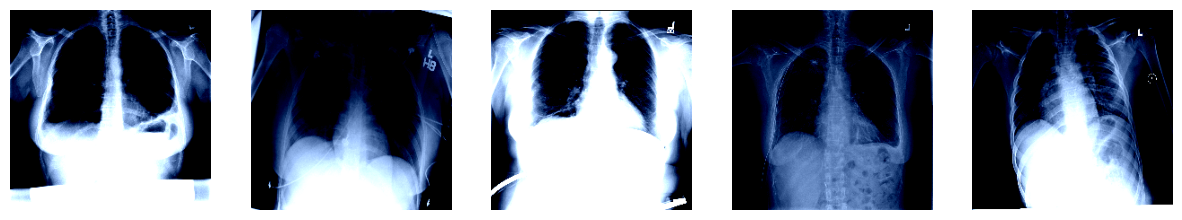

In [11]:
def plot_preprocessed_images(generator, unique_labels, num_images=5):
    """
    Plot some preprocessed images from the generator.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        # Generate a batch from the generator
        batch = generator[i]

        # Get the preprocessed images from the batch
        images = batch[0]

        # Convert unique_labels set to a list
        unique_labels_list = list(unique_labels)

        # Plot the preprocessed images
        axes[i].imshow(images[0])
        axes[i].axis('off')

    plt.show()

# Use the function to plot preprocessed images before training
plot_preprocessed_images(train_generator, unique_labels)

In [12]:
class MultiLabelCrossEntropy:
    """
    Weight Cross Entropy Loss.
    
    For each class we will found two weights corresponding to the positive and negative frequency of our sample data.
    These weights will manage the way we update our network. And this has for objectives to manage the unbalanced class issue.
    """
        
    def __init__(self, labels : DataFrame, epsilon = 1e-7):
        
        self.epsilon = epsilon
        
        # Get the size of the data
        self.N = labels.shape[0]
        
        # Get the frequency occurence for each class
        self.freq_pos = np.sum(labels == 1, axis=0) / self.N
        self.freq_neg = np.sum(labels == 0, axis=0) / self.N
        
        # Set the loss weights for each labels 
        self.pos_weights = self.freq_neg
        self.neg_weights = self.freq_pos
        
    def contribution(self):
        """
        Get the weights' contribution for each labels.
        
        Returns :
            - double : Positive contribution
            - double : Negative contribution
        """
        return self.freq_pos * self.pos_weights, self.freq_neg * self.neg_weights
        
        
    def loss(self, y_true, y_pred):
        """
        Return weighted loss value. 
        """
        # Initialize loss to zero
        loss = 0.0
        
        for i in range(len(self.pos_weights)):
            loss += (-1 * K.mean(
                        self.pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + self.epsilon))
                    ) + (-1 * K.mean(
                        self.neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + self.epsilon))
                    )
        return loss

In [13]:
cross_entropy_loss = MultiLabelCrossEntropy(X_train[list(unique_labels)])


pos_contribution, neg_contribution = cross_entropy_loss.contribution()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

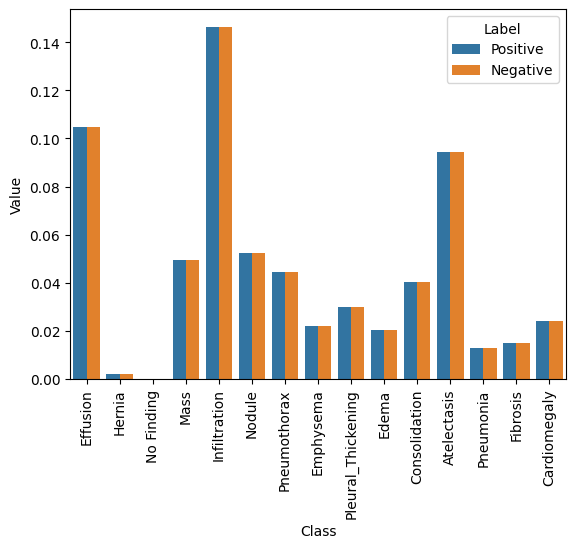

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

labels = list(unique_labels)

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = pd.concat([data, pd.DataFrame({"Class": labels, "Label": "Negative", "Value": neg_contribution})], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()


Note : For the model, we could use other alternatives as DenseNet ...

In [15]:
# def create_efficientB_model(cross_entropy_loss):
    
#     inputs = Input(shape=(224, 224, 3))
#     model = EfficientNetB0(input_tensor=inputs, weights='imagenet', include_top=False)
#     model.trainable = False # Freeze the layer
    
#     # Rebuild top
#     x = GlobalAveragePooling2D(name="avg_pool")(model.output)
#     x = BatchNormalization()(x)

#     x = Dropout(0.2, name="top_dropout")(x)
#     outputs = Dense(NB_LABELS, activation="sigmoid", name="pred")(x)
    
#     # Compile
#     model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    
#     # Note : Possibility to assign a learning rate.
#     model.compile(optimizer=Adam(), 
#                   loss = cross_entropy_loss.loss,
#                   metrics=[
#         'accuracy',
#         tf.keras.metrics.Recall(),
#         tfa.metrics.F1Score(num_classes = NB_LABELS, threshold=0.5),
#         tf.keras.metrics.AUC(multi_label = True)
#     ])
    
#     return model

# model = create_efficientB_model(cross_entropy_loss)

In [16]:
def create_densenet_model(cross_entropy_loss):
    base_model = DenseNet121(
        include_top=False, weights="imagenet", input_tensor=Input(shape=(224, 224, 3))
    )
    base_model.trainable = False  # Freeze the layer

    # Rebuild top
    x = GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.2, name="top_dropout")(x)
    outputs = Dense(NB_LABELS, activation="sigmoid", name="pred")(x)

    # Compile
    model = Model(base_model.input, outputs, name="DenseNet")
    model.compile(
        optimizer=Adam(),
        loss=cross_entropy_loss.loss,
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Recall(),
            tfa.metrics.F1Score(num_classes=NB_LABELS, threshold=0.5),
            tf.keras.metrics.AUC(multi_label=True),
        ],
    )

    return model

model = create_densenet_model(cross_entropy_loss)

29084464/29084464 [==============================] - 2s 0us/step


In [17]:
# history = model.fit(train_generator, validation_data=valid_generator, epochs = 8, batch_size = BATCH_SIZE)

In [21]:
model_path = '/kaggle/input/output/model'
model = tf.keras.models.load_model(model_path, custom_objects={'loss': cross_entropy_loss.loss})

In [27]:
# Save the model 
model.save("model")

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])

plt.title('model recall')
plt.ylabel('recall_1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])

plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])

plt.title('model auc')
plt.ylabel('auc_1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test phase

In [23]:
test_generator = ChestImagesDataset(df_test, DATA_DIR, batch_size = BATCH_SIZE, transform = None, training = False, shuffle = False)

predictions = model.predict(test_generator)

216/216 [==============================] - 432s 2s/step


In [32]:
roc_auc_score(df_test[list(unique_labels)].values, predictions)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

Error in generating ROC curve for No Finding. Dataset lacks enough examples.


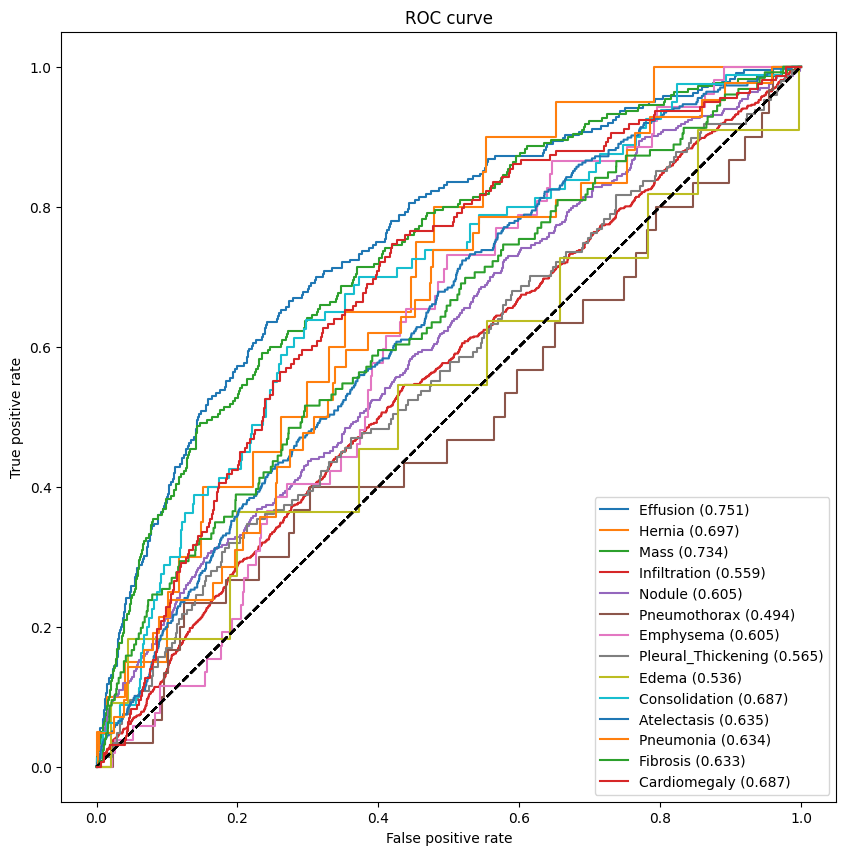

[0.7510822400586702,
 0.6968349825378347,
 0.7344758284281666,
 0.5591445328559917,
 0.6052184703807719,
 0.49424851841057027,
 0.6046108861898335,
 0.5653136866310646,
 0.5362460530314039,
 0.6868705960070465,
 0.6346905506406345,
 0.634365658672228,
 0.632894279990053,
 0.6873113202227126]

In [31]:
## Metrics

def get_roc_curve(labels, predicted_vals, real_vals):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = real_vals[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals


get_roc_curve(list(unique_labels), predictions, df_test[list(unique_labels)].values)